<a href="https://colab.research.google.com/github/u-keigo/RRIproject1/blob/main/SVNS%E5%88%86%E9%A1%9E%E3%83%A2%E3%83%87%E3%83%AB%EF%BC%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SV NSモデル


108個のHRVデータを利用
しかしながら分類結果がすべてSVとなっており実装に失敗している

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime

RRI_max = 1500
RRI_min = 350
RRI_diff = 150
dt = 0.5   # second

def read_RRI(name, RRI_max, RRI_min, RRI_diff, dt):
  nums = []  # 整数を入れるリスト

  with open(name, 'r', encoding='utf-8') as fin:  # ファイルを開く
    for line in fin.readlines():  # 行を読み込んでfor文で回す
        try:
            line = line.replace('\n','')
            num = int(float(line))  # 行を整数（int）に変換する
        except ValueError as e:
            print(e, file=sys.stderr)  # エラーが出たら画面に出力
            continue

        nums.append(num)  # 変換した整数をリストに保存する


  # 日付の取得（もっといいやり方があるはず)
  f = open(name, 'r', encoding='utf-8')
  tstr = f.readline()
  try:
    tstr = tstr.replace('\n','')
    timestart = datetime.datetime.strptime(tstr, '%H:%M:%S')
  except:
    timestart = datetime.datetime(2016, 1, 1, 9, 0, 0)

  time_RRI = []  # 時刻データを入れるリスト
  time_RRI2 = [] # 経過時間(ms)

  timecount = 0
  for i in range(len(nums)):
    timecount = timecount + nums[i]/1000  # second
    time_RRI2.append(timecount)  # second
    time = timestart + datetime.timedelta(seconds=round(timecount,2))
    time_RRI.append(time)

  f.close()


  # RRIデータのクリーニング

  # リストをnumpy配列に変換(これをしないとif文の不等号でエラーが発生する)
  time_RRI2x = np.array(time_RRI2)
  numsx = np.array(nums)
  time_RRI2 = time_RRI2x
  nums = numsx

  cleaning_counter = 0
  RRI_cleaning = np.empty(0)
  time_RRIa = []  # リスト型(日付時刻データのため)
  time_RRI2a = np.empty(0)

  for i in range(len(nums)):
    if RRI_min < nums[i] and nums[i] < RRI_max:
      RRI_cleaning = np.append(RRI_cleaning,nums[i]) 
      time_RRIa.append(time_RRI[i])  # リスト型
      time_RRI2a = np.append(time_RRI2a,time_RRI2[i])
    else:
      cleaning_counter += 1  # クリーニングで消去した要素数を数える

  nums = RRI_cleaning
  time_RRI = time_RRIa
  time_RRI2 = time_RRI2a

  RRI_cleaning = np.empty(0)
  time_RRIa = []  # リスト型(日付時刻データのため)
  time_RRI2a = np.empty(0)

  cleaning_counter = 0
  for i in range(len(nums)-1):   #範囲を超えないように-1する
    if nums[i+1] - nums[i] < RRI_diff:
      RRI_cleaning = np.append(RRI_cleaning,nums[i]) 
      time_RRIa.append(time_RRI[i])  # リスト型
      time_RRI2a = np.append(time_RRI2a,time_RRI2[i])
    else:
      cleaning_counter += 1  # クリーニングで消去した要素数を数える

  time_RRI2 = time_RRI2a
  nums = RRI_cleaning
  time_RRI = time_RRIa

  # クリーニング後のリサンプリング

  T_samp = datetime.timedelta(seconds = 0.5)  # second
  samp_len = int(time_RRI2[-1] / dt)  # サンプリング数
  t_resamp = [timestart + x * T_samp for x in range(samp_len)]  # リサンプリング点での時刻データ

  # interp関数はdatetime型を受け付けない
  # 時刻をdatetime型からunix時間（float）に変換する
  t_unix = [x.timestamp() for x in time_RRI]
  t_new_unix = [x.timestamp() for x in t_resamp]

  RRI_resamp = np.interp(t_new_unix, t_unix, RRI_cleaning)

  return (t_resamp, RRI_resamp)

In [3]:
import os
from glob import glob
import pandas as pd
import linecache


# カテゴリを配列で取得
drive_dir = "/content/drive/My Drive/python/HRV_CHF/"

categories = [name for name in os.listdir(drive_dir + '24h') if os.path.isdir(drive_dir + "24h/" +name)]
print(categories)


['NS_24h', 'SV_24h']


In [4]:
import numpy as np

fix_length = 2000   # 取り出すデータ点の数
num_SV = 73   # SVファイルの数
num_NS = 45   # NSファイルの数
num_data = num_SV + num_NS   # ファイルの数

DAT = pd.DataFrame(np.zeros(shape=(fix_length, num_data)))
i=0
for cat in categories:
    path = drive_dir + "24h/" + cat + "/*.24h"
    files = glob(path)
    for text_name in files:
      _, RRI_resamp = read_RRI(text_name, RRI_max, RRI_min, RRI_diff, dt)
      data = pd.Series(RRI_resamp)
      DAT.iloc[:, i] = data
      DAT.rename(columns={i: cat}, inplace=True)
      i = i+1


          NS_24h      NS_24h      NS_24h  ...      SV_24h      SV_24h      SV_24h
0     736.000000  648.000000  640.000000  ...  704.000000  768.000000  560.000000
1     736.000000  648.000000  640.000000  ...  704.000000  768.000000  560.000000
2     736.000000  652.307692  644.430769  ...  700.571429  765.578947  560.000000
3     736.639999  648.499999  642.666667  ...  696.000000  760.315789  565.333333
4     747.306666  636.235291  633.969229  ...  696.000000  774.461540  568.000000
...          ...         ...         ...  ...         ...         ...         ...
1995  790.153845  669.731343  618.322579  ...  688.000000  794.700000  592.275862
1996  781.948717  664.000000  627.174603  ...  686.705883  799.700000  589.333333
1997  776.820512  664.000000  635.875000  ...  680.823529  790.481012  600.000000
1998  784.506331  664.000000  640.000000  ...  674.865671  785.822786  600.000000
1999  795.851854  666.352942  639.619048  ...  675.058823  790.886077  593.220338

[2000 rows x 10

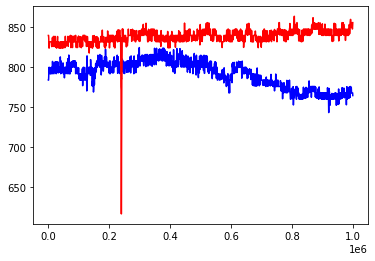

In [5]:
import matplotlib.pyplot as plt

# データがうまく取れている列のみ抽出
DAT2 = DAT.loc[:,['NS_24h','SV_24h']]
print(DAT2)

DAT3 = DAT2.sample(frac=1,axis=1).reset_index(drop=True)
DAT4 = DAT3.T
DAT4.head()

time_resamp = range(0, fix_length*500,500)
plt.figure()
plt.plot(time_resamp, DAT4.iloc[1], color='blue')
plt.plot(time_resamp, DAT4.iloc[4], color='red')

In [6]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim


category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)
# {'NS_24h': 0, 'SV_24h': 1}

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)

# データフレームの形状変更・indexの要素化
df = DAT4
df['index'] = df.index
df.head()

dlen = len(DAT3.columns)  # 108
train_data, test_data = train_test_split(df, test_size=0.3,random_state=0)
print("train_data size: {}". format(train_data.shape))
# train_data size: (75, 2001)
print("test_data size: {}". format(test_data.shape))
# test_data size: (33, 2001)

# DataLoaderを使って、データセットを128個のミニパッチに分ける
# ミニパッチサイズを指定したデータローダを作成
train_batch = DataLoader(
    dataset = train_data,   # データセットの指定
    batch_size = 16,   # バッチサイズの指定
    shuffle = True,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

test_batch = DataLoader(
    dataset = test_data,   # データセットの指定
    batch_size = 16,   # バッチサイズの指定
    shuffle = False,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数


{'NS_24h': 0, 'SV_24h': 1}
train_data size: (75, 2001)
test_data size: (33, 2001)


In [7]:
# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax(dim=1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力。2次元のテンソル
        # embeds = self.word_embeddings(sentence)
        embeds = sentence
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
        # softmaxに食わせて、確率として表現
        tag_scores = self.softmax(tag_space)
        return tag_scores

category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)
#{'movie-enter': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'topic-news': 3, 'livedoor-homme': 4, 'peachy': 5, 'sports-watch': 6, 'dokujo-tsushin': 7, 'smax': 8}

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)



{'NS_24h': 0, 'SV_24h': 1}


In [8]:
# 入力次元数
EMBEDDING_DIM = 1
# 隠れ層の次元数
HIDDEN_DIM = 128
# 分類先のカテゴリの数
TAG_SIZE = len(categories)


# ネットワークのロード
# CPUとGPUのどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# モデル宣言
net = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, TAG_SIZE).to(device)
# デバイスの確認
print("Device: {}".format(device))


# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化関数の定義
optimizer = optim.Adam(net.parameters())
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
# optimizer = optim.SGD(net.parameters(), lr=0.01)


# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

epoch = 100

# 各エポックの合計loss値を格納する
losses = []
# 100ループ回してみる。
for i in range(epoch):
  all_loss = 0
  # エポックの進行状況を表示
  print('-------------------------------------')
  print("Epoch: {}/{}".format(i+1,epoch))

  # 損失の初期化
  # train_loss = 0  # 学習損失
  # test_loss = 0  # 評価損失

  # ---学習パート--- #
  # ニューラルネットワークを学習モードに設定
  # net.train()
  for ii in range(0,len(train_data)):
        data = train_data.iloc[ii][:-1]
        cat = train_data.iloc[ii]['index']
        # モデルが持ってる勾配の情報をリセット
        net.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        inputs = torch.tensor(np.array(data.astype('f')))
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # 順伝播の結果を受け取る
        out = net(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # GPUにTensorを転送
        answer = answer.to(device)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
  losses.append(all_loss)
  print("epoch", i+1, "\t" , "loss", all_loss)
print("done.")

Device: cuda
-------------------------------------
Epoch: 1/100
epoch 1 	 loss 49.07367143034935
-------------------------------------
Epoch: 2/100
epoch 2 	 loss 48.564082354307175
-------------------------------------
Epoch: 3/100
epoch 3 	 loss 48.70081624388695
-------------------------------------
Epoch: 4/100
epoch 4 	 loss 48.59076061844826
-------------------------------------
Epoch: 5/100
epoch 5 	 loss 48.56824600696564
-------------------------------------
Epoch: 6/100
epoch 6 	 loss 48.73136883974075
-------------------------------------
Epoch: 7/100
epoch 7 	 loss 48.53722822666168
-------------------------------------
Epoch: 8/100
epoch 8 	 loss 48.649217277765274
-------------------------------------
Epoch: 9/100
epoch 9 	 loss 48.652818739414215
-------------------------------------
Epoch: 10/100
epoch 10 	 loss 48.75472703576088
-------------------------------------
Epoch: 11/100
epoch 11 	 loss 48.67400959134102
-------------------------------------
Epoch: 12/100
epoc

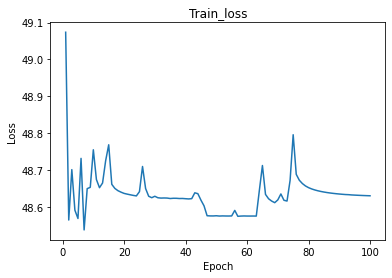

In [15]:
import matplotlib.pyplot as plt
# 損失
fig2 = plt.figure()
plt.title('Train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), losses)
plt.show()


In [16]:
# テストデータの母数計算
test_num = len(test_data)
# 正解の件数
a = 0
# 勾配自動計算OFF
with torch.no_grad():
    for ii in range(0,len(test_data)):
        data = test_data.iloc[ii][:-1]
        # cat = train_data.iloc[ii][0]
        cat = test_data.iloc[ii]['index']

        inputs = torch.tensor(np.array(data.astype('f')))
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # 順伝播の結果を受け取る
        out = net(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # GPUにTensorを転送
        answer = answer.to(device)
        # 正解とのlossを計算
        # loss = loss_function(out, answer)
        # inputs = sentence2index(title)
        # out = model(inputs)
        _, predict = torch.max(out, 1)
        # answer = category2tensor(cat)
        if predict == answer:
            a += 1
print("predict : ", a / test_num)
# predict :  0.5757575757575758(19/33)


predict :  0.5757575757575758


In [19]:
traindata_num = len(train_data)
a = 0
with torch.no_grad():
    for ii in range(0,len(train_data)):
        data = train_data.iloc[ii][:-1]
        # cat = train_data.iloc[ii][0]
        cat = train_data.iloc[ii]['index']

        inputs = torch.tensor(np.array(data.astype('f')))
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # 順伝播の結果を受け取る
        out = net(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # GPUにTensorを転送
        answer = answer.to(device)
        # 正解とのlossを計算
        # loss = loss_function(out, answer)
        # inputs = sentence2index(title)
        # out = model(inputs)
        _, predict = torch.max(out, 1)
        # answer = category2tensor(cat)
        if predict == answer:
            a += 1
print("predict : ", a / traindata_num)
# predict :  0.6666666666666666(50/75)

import collections
# IDをカテゴリに戻す用
index2category = {}
for cat, idx in category2index.items():
    index2category[idx] = cat

# answer -> 正解ラベル、predict->LSTMの予測結果、exact->正解してたらO,間違っていたらX
predict_df = pd.DataFrame(columns=["answer", "predict", "exact"])

# 予測して結果を上のDFに格納
with torch.no_grad():
    for ii in range(0,len(test_data)):
        data = test_data.iloc[ii][:-1]
        cat = test_data.iloc[ii]['index']

        inputs = torch.tensor(np.array(data.astype('f')))
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # 順伝播の結果を受け取る
        out = net(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # GPUにTensorを転送
        answer = answer.to(device)

        # out = model(sentence2index(title))
        _, predict = torch.max(out, 1)
        # answer = category2tensor(category)
        exact = "O" if predict.item() == answer.item() else "X"
        s = pd.Series([answer.item(), predict.item(), exact], index=predict_df.columns)
        predict_df = predict_df.append(s, ignore_index=True)

print(predict_df)


# # Fスコア格納用のDF
# fscore_df = pd.DataFrame(columns=["category", "all","precison", "recall", "fscore"])

# # 分類器が答えた各カテゴリの件数
# prediction_count = collections.Counter(predict_df["predict"])
# # 各カテゴリの総件数
# answer_count = collections.Counter(predict_df["answer"])

# # Fスコア求める
# for i in range(TAG_SIZE):
#     all_count = answer_count[i]
#     precision = len(predict_df.query('predict == ' + str(i) + ' and exact == "O"')) / prediction_count[i]
#     recall = len(predict_df.query('answer == ' + str(i) + ' and exact == "O"')) / all_count
#     fscore = 2*precision*recall / (precision + recall)
#     s = pd.Series([index2category[i], all_count, round(precision, 2), round(recall, 2), round(fscore, 2)], index=fscore_df.columns)
#     fscore_df = fscore_df.append(s, ignore_index=True)
# print(fscore_df)

predict :  0.6666666666666666
   answer predict exact
0       1       1     O
1       0       1     X
2       0       1     X
3       1       1     O
4       0       1     X
5       1       1     O
6       1       1     O
7       0       1     X
8       1       1     O
9       1       1     O
10      1       1     O
11      1       1     O
12      1       1     O
13      1       1     O
14      0       1     X
15      0       1     X
16      1       1     O
17      0       1     X
18      1       1     O
19      0       1     X
20      1       1     O
21      0       1     X
22      1       1     O
23      1       1     O
24      1       1     O
25      0       1     X
26      0       1     X
27      0       1     X
28      1       1     O
29      1       1     O
30      0       1     X
31      1       1     O
32      0       1     X
